# Алгоритм REINFORCE

Применим алгоритм REINFORCE для обучения агента. Как и ранее напишем отдельный класс для агента. Ключевым объектом будет ИНС, которая является параметризованной стратегией, то есть на вход ИНС получает состояние $s$, а на выходе выдает распределение вероятностей $\pi(a|s)$. 

Для генерации траектории по текущей стратегии (то есть для текущего набора параметров ИНС) в ИНС отравляются состояния, которая выдаёт распределение вероятностей выбора действий, в соответствии с которым выбираются действия. Это удобно делать с помощью специального класса `PyTorch`, реализующего категориальное распределение вероятностей.

Управляющий метод получает траекторию и отправляет эту информацию агенту, который вычисляет градиенты по параметрам при аргументах равных поданным состояниям в соотвествии с формулой из лекций. 

In [3]:
import gymnasium as gym
import numpy as np  

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

import matplotlib.pyplot as plt
from tqdm import tqdm
import os 
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
# для избежания ошибки при отрисовки графиков

Приведём пример класса с ИНС, который будет являться параметризованной стратегией. После полносвязных слоёв ИНС должна выдавать вектор вероятностей выбора действия, поэтому последней функцией активации ИНС будет функция `softmax()`. Далее, при реализации в `PyTorch` удобно вектор вероятностей на выходе ИНС представить как экземпляр класса `Categorical`, реализующего сооветствующее категориальное распределение.

Под каждую задачу надо подбирать свою архитектуру ИНС. Пример такой архитектуры приведён ниже.

In [7]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, action_size)
        
    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        prob_distribution = Categorical(F.softmax(x, dim=-1))
        return prob_distribution

Далее, реализуем класс агента. Ему передаются среда и ИНС. Также, этот класс имеет стандартный набор методов

    get_action()
    best_action()
    update()

А также есть возможность сохранить обученную ИНС.

In [11]:
class REINFORCE_Agent():
    def __init__(self, env, model, alpha=0.01, gamma=0.99, normalize = True):
        # инициализация полей
        self.alpha = alpha
        self.gamma = gamma
        self.nA = env.action_space.n
        self.normalize = normalize

        # инициализация ИНС и оптимизатора
        self.policy_net = model
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.alpha)
        # вектор для хранения логарифмов вероятностей
        self.log_probs = []

    # Использовать только для обучения, так как сохраняются лог-вероятности
    def get_action(self, state):
        state = torch.tensor(state).float()
        prob_distribution = self.policy_net(state)
        action_tensor = prob_distribution.sample()
        log_prob = prob_distribution.log_prob(action_tensor).unsqueeze(0) 
        self.log_probs.append(log_prob)
        action = action_tensor.item()
        return action
        
    # получить действие по текущей стратегии   
    def best_action(self, state):
        state = torch.tensor(state).float()
        # вычисляем отклик ИНС без обучения
        with torch.no_grad():
            prob_distribution = self.policy_net(state)
            action_tensor = prob_distribution.sample()
            action = action_tensor.item()
        return action
    
    def update(self, rewards):
        gains = []
        gain = 0
        for step in reversed(range(len(rewards))):
            gain = rewards[step] + self.gamma * gain 
            gains.insert(0, gain)
            
        gains = torch.tensor(gains)
        if self.normalize:
            gains = (gains - gains.mean()) / (gains.std() + 1e-9) # нормализуем доходы для стабильности обучения
    
        loss = []
        for log_prob, gain in zip(self.log_probs, gains):
            loss.append(-log_prob * gain)
        loss = torch.stack(loss).sum()
        #loss = self.log_probs @ gains
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.log_probs = []

    def play(self, env, n_episodes):
        for episode in tqdm(range(n_episodes)):
            state, _ = env.reset()
            while True:
                # выбираем действия по стратегии
                action = agent.best_action(state)
                state, reward, terminated, truncated, _ = env.step(action)
                if terminated or truncated:
                    break

             
    def save_model(self, fname):
        torch.save(self.policy_net, 'savedModels/' + fname +'.pkl')
        print('Saved: savedModels/' + fname +'.pkl')
        
    def load_model(self, fname):
        if os.path.exists(fname):
            self.policy_net = torch.load(fname, map_location=torch.device('cpu'), weights_only=False)
            print('Loaded')
        else:
            print("No such file")

In [21]:
def REINFORCE_control(env, agent, n_episodes=10000, goal_score=250):
    for i in range(n_episodes):
        state, _ = env.reset()    
        rewards = []   
        while True:
            action = agent.get_action(state)
            state, reward, terminated, truncated, _ = env.step(action)
            rewards.append(reward)
            if terminated or truncated:
                    break
            
        # обучение агента
        agent.update(rewards)
        
        if i % 10 == 0:
            running_gain = np.mean(np.array(env.return_queue)[-50:])
            print("\rДоход: {:.2f} в эпизоде {}".format(running_gain, i))

            if running_gain > goal_score:  
                print("Успех на эпизоде {}!".format(i))
                break

# Задача 1 

Рассмотрим работу метода REINFORCE на задаче об обратном маятнике. Модель будет иметь 2 скрытых слоя нейронов ширины 32 нейрона.

In [23]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, action_size)
        
    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        prob_distribution = Categorical(F.softmax(x, dim=-1))
        return prob_distribution
        
env = gym.make('CartPole-v1')
env = gym.wrappers.RecordEpisodeStatistics(env,2000)
model = QNetwork(env.observation_space.shape[0], env.action_space.n)

In [25]:
agent = REINFORCE_Agent(env, model, alpha = 0.01)

state, _ = env.reset()
agent.best_action(state)

1

In [27]:
REINFORCE_control(env, agent, n_episodes=1000, goal_score=400)

Доход: 32.00 в эпизоде 0
Доход: 21.82 в эпизоде 10
Доход: 23.81 в эпизоде 20
Доход: 22.32 в эпизоде 30
Доход: 21.49 в эпизоде 40
Доход: 21.62 в эпизоде 50
Доход: 26.18 в эпизоде 60
Доход: 31.76 в эпизоде 70
Доход: 39.44 в эпизоде 80
Доход: 53.30 в эпизоде 90
Доход: 69.22 в эпизоде 100
Доход: 75.08 в эпизоде 110
Доход: 88.82 в эпизоде 120
Доход: 126.16 в эпизоде 130
Доход: 123.98 в эпизоде 140
Доход: 115.54 в эпизоде 150
Доход: 111.04 в эпизоде 160
Доход: 98.20 в эпизоде 170
Доход: 62.08 в эпизоде 180
Доход: 81.52 в эпизоде 190
Доход: 94.18 в эпизоде 200
Доход: 137.32 в эпизоде 210
Доход: 225.34 в эпизоде 220
Доход: 305.20 в эпизоде 230
Доход: 318.82 в эпизоде 240
Доход: 341.84 в эпизоде 250
Доход: 370.04 в эпизоде 260
Доход: 368.02 в эпизоде 270
Доход: 338.22 в эпизоде 280
Доход: 304.90 в эпизоде 290
Доход: 311.74 в эпизоде 300
Доход: 330.32 в эпизоде 310
Доход: 331.32 в эпизоде 320
Доход: 368.52 в эпизоде 330
Доход: 416.96 в эпизоде 340
Успех на эпизоде 340!


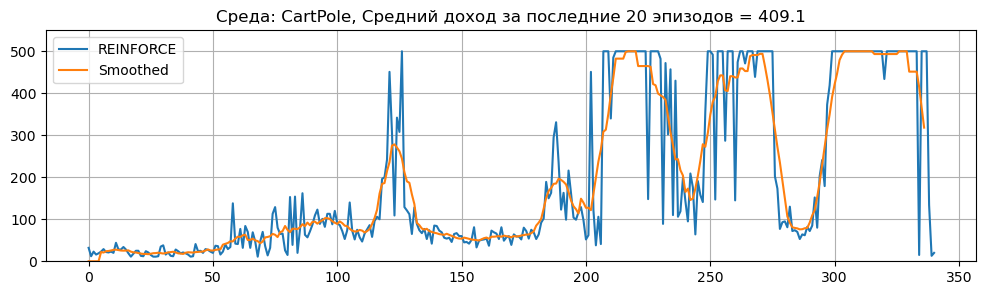

In [29]:
def plot_rewards(env_name, returns, label):
    # сглаженный вектор доходов
    returns_smoothed = np.pad(np.convolve(returns, np.ones(10)/10, mode='valid'),[5, 0])
    fig = plt.figure(figsize=(12, 3))
    plt.title("Среда: "+env_name+", Средний доход за последние 20 эпизодов = "+str(np.mean(returns[-20:])))
    plt.plot(returns, label=label)
    plt.plot(returns_smoothed, label="Smoothed")
    plt.grid()
    plt.legend()
    plt.ylim(0, 550)
    plt.show()

returns = np.array(env.return_queue)
plot_rewards("CartPole", returns, 'REINFORCE')

In [55]:
agent.save_model('REINFORCE_CartPole_32_32neurons')

Saved: savedModels/REINFORCE_CartPole_32_32neurons.pkl


In [35]:
agent.load_model('savedModels/REINFORCE_CartPole_32_32neurons.pkl')

No such file


In [31]:
env = gym.make('CartPole-v1')
env = gym.wrappers.RecordEpisodeStatistics(env, 100)
agent.play(env,100)

print("Средний доход: ", np.mean(env.return_queue))
print("Минимальный доход: ", np.min(env.return_queue))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.51it/s]

Средний доход:  192.01
Минимальный доход:  9.0


In [33]:
# демонстрация работы агента
env = gym.make('CartPole-v1', render_mode='human')
env = gym.wrappers.RecordEpisodeStatistics(env)

agent.play(env,1)
print("Число шагов:", env.return_queue[-1])

env.close()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.36s/it]

Число шагов: 157.0


# Задача 2

Рассмотрим также задачу о посадке лунного модуля.

Хотя пространство состояний имеет большую размерность, применим такую же по структуре модель, что и в задаче о маятнике.
Обучение будет идти дольше, порядка нескольких тысяч эпизодов.

In [73]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, action_size)
        
    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        prob_distribution = Categorical(F.softmax(x, dim=-1))
        return prob_distribution
        
env = gym.make("LunarLander-v3")  
env = gym.wrappers.RecordEpisodeStatistics(env,2000)
model = QNetwork(env.observation_space.shape[0], env.action_space.n)

In [75]:
agent = REINFORCE_Agent(env, model, alpha = 0.0025)

state, _ = env.reset()
agent.best_action(state)

0

In [77]:
REINFORCE_control(env, agent, n_episodes=2000, goal_score=200)

Доход: -154.65 в эпизоде 0
Доход: -192.72 в эпизоде 10
Доход: -231.30 в эпизоде 20
Доход: -214.34 в эпизоде 30
Доход: -224.71 в эпизоде 40
Доход: -204.83 в эпизоде 50
Доход: -208.89 в эпизоде 60
Доход: -190.48 в эпизоде 70
Доход: -199.64 в эпизоде 80
Доход: -184.64 в эпизоде 90
Доход: -194.55 в эпизоде 100
Доход: -184.42 в эпизоде 110
Доход: -182.54 в эпизоде 120
Доход: -181.10 в эпизоде 130
Доход: -182.54 в эпизоде 140
Доход: -182.46 в эпизоде 150
Доход: -191.47 в эпизоде 160
Доход: -212.19 в эпизоде 170
Доход: -206.80 в эпизоде 180
Доход: -199.79 в эпизоде 190
Доход: -195.25 в эпизоде 200
Доход: -178.57 в эпизоде 210
Доход: -144.06 в эпизоде 220
Доход: -136.04 в эпизоде 230
Доход: -137.76 в эпизоде 240
Доход: -124.41 в эпизоде 250
Доход: -111.58 в эпизоде 260
Доход: -115.81 в эпизоде 270
Доход: -102.67 в эпизоде 280
Доход: -97.16 в эпизоде 290
Доход: -89.55 в эпизоде 300
Доход: -84.89 в эпизоде 310
Доход: -77.68 в эпизоде 320
Доход: -81.96 в эпизоде 330
Доход: -78.27 в эпизоде 340
До

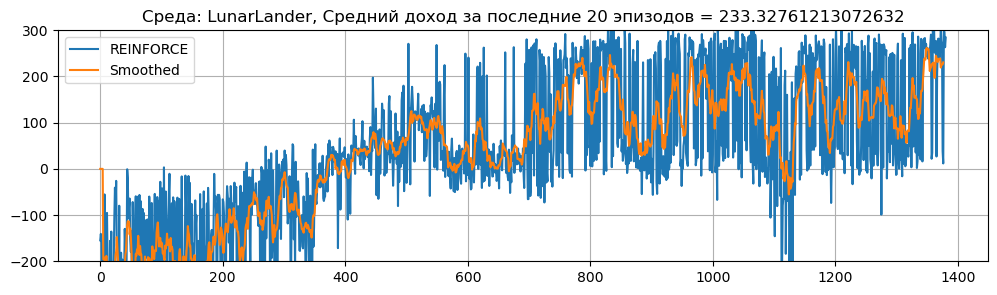

In [79]:
def plot_rewards(env_name, returns, label):
    # сглаженный вектор доходов
    returns_smoothed = np.pad(np.convolve(returns, np.ones(10)/10, mode='valid'),[5, 0])
    fig = plt.figure(figsize=(12, 3))
    plt.title("Среда: "+env_name+", Средний доход за последние 20 эпизодов = "+str(np.mean(returns[-20:])))
    plt.plot(returns, label=label)
    plt.plot(returns_smoothed, label="Smoothed")
    plt.grid()
    plt.legend()
    plt.ylim(-200, 300)
    plt.show()

returns = np.array(env.return_queue)
plot_rewards("LunarLander", returns, 'REINFORCE')

In [81]:
agent.save_model('REINFORCE_LunarLander_32_32neurons')

Saved: savedModels/REINFORCE_LunarLander_32_32neurons.pkl


In [87]:
agent.load_model('savedModels/REINFORCE_LunarLander_32_32neurons.pkl')

Loaded


Проделаем симуляции с обученным агентом.

In [89]:
env = gym.make("LunarLander-v3")  
env = gym.wrappers.RecordEpisodeStatistics(env, 100)
agent.play(env,100)

print("Средний доход: ", np.mean(env.return_queue))
print("Минимальный доход: ", np.min(env.return_queue))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.74it/s]

Средний доход:  211.12583438424528
Минимальный доход:  -127.72670916136073


In [90]:
# демонстрация работы агента
env = gym.make('LunarLander-v3', render_mode='human')
env = gym.wrappers.RecordEpisodeStatistics(env)

agent.play(env,1)
print("Число шагов:", env.return_queue[-1])

env.close()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.51s/it]

Число шагов: 11.052186570824006


Рассмотрим модель с большим числом нейронов в одном скрытом слое для этой же задачи.

In [101]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 192)
        self.fc2 = nn.Linear(192, action_size)
        
    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        prob_distribution = Categorical(F.softmax(x, dim=-1))
        return prob_distribution
        
env = gym.make("LunarLander-v3")  
env = gym.wrappers.RecordEpisodeStatistics(env,2500)
model = QNetwork(env.observation_space.shape[0], env.action_space.n)

In [103]:
agent = REINFORCE_Agent(env, model, alpha = 0.003)

state, _ = env.reset()
agent.best_action(state)

1

In [105]:
gains = REINFORCE_control(env, agent, n_episodes=2500, goal_score=225)

Доход: -143.61 в эпизоде 0
Доход: -230.74 в эпизоде 10
Доход: -325.64 в эпизоде 20
Доход: -335.70 в эпизоде 30
Доход: -344.60 в эпизоде 40
Доход: -355.74 в эпизоде 50
Доход: -369.29 в эпизоде 60
Доход: -325.83 в эпизоде 70
Доход: -286.65 в эпизоде 80
Доход: -251.99 в эпизоде 90
Доход: -193.41 в эпизоде 100
Доход: -156.48 в эпизоде 110
Доход: -136.28 в эпизоде 120
Доход: -125.59 в эпизоде 130
Доход: -109.39 в эпизоде 140
Доход: -119.99 в эпизоде 150
Доход: -107.15 в эпизоде 160
Доход: -109.83 в эпизоде 170
Доход: -108.56 в эпизоде 180
Доход: -96.22 в эпизоде 190
Доход: -84.50 в эпизоде 200
Доход: -88.71 в эпизоде 210
Доход: -69.34 в эпизоде 220
Доход: -56.25 в эпизоде 230
Доход: -57.24 в эпизоде 240
Доход: -50.48 в эпизоде 250
Доход: -45.89 в эпизоде 260
Доход: -48.87 в эпизоде 270
Доход: -57.29 в эпизоде 280
Доход: -47.23 в эпизоде 290
Доход: -41.48 в эпизоде 300
Доход: -41.78 в эпизоде 310
Доход: -50.30 в эпизоде 320
Доход: -53.33 в эпизоде 330
Доход: -50.32 в эпизоде 340
Доход: -44.0

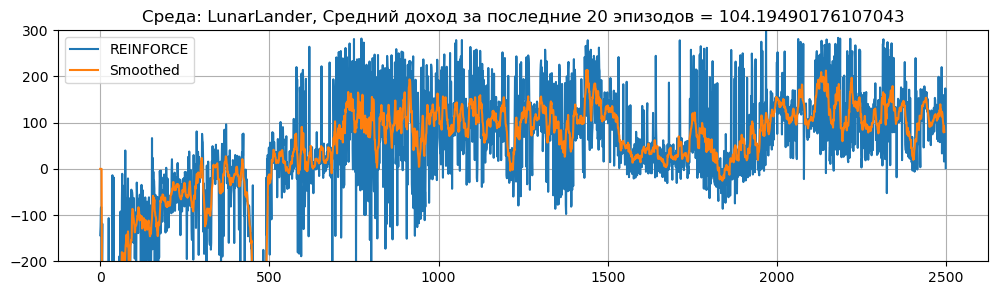

In [107]:
def plot_rewards(env_name, returns, label):
    # сглаженный вектор доходов
    returns_smoothed = np.pad(np.convolve(returns, np.ones(10)/10, mode='valid'),[5, 0])
    fig = plt.figure(figsize=(12, 3))
    plt.title("Среда: "+env_name+", Средний доход за последние 20 эпизодов = "+str(np.mean(returns[-20:])))
    plt.plot(returns, label=label)
    plt.plot(returns_smoothed, label="Smoothed")
    plt.grid()
    plt.legend()
    plt.ylim(-200, 300)
    plt.show()

returns = np.array(env.return_queue)
plot_rewards("LunarLander", returns, 'REINFORCE')

In [78]:
agent.save_model('REINFORCE_LunarLander_192neurons')

Saved: savedModels/REINFORCE_LunarLander_192neurons.pkl


In [113]:
agent.load_model('savedModels/REINFORCE_LunarLander_192neurons.pkl')

Loaded


In [119]:
env = gym.make("LunarLander-v3")  
env = gym.wrappers.RecordEpisodeStatistics(env, 100)

agent.play(env,100)

print("Средний доход: ", np.mean(env.return_queue))
print("Минимальный доход: ", np.min(env.return_queue))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.60it/s]

Средний доход:  226.08845221542148
Минимальный доход:  20.56422142375591


In [121]:
# демонстрация работы агента
env = gym.make('LunarLander-v3', render_mode='human')
env = gym.wrappers.RecordEpisodeStatistics(env)

agent.play(env,1)
print("Число шагов:", env.return_queue[-1])

env.close()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.72s/it]

Число шагов: 264.7845003320649


# Задача 3

Рассмотрим задачу о машине и холме.

In [125]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        #self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, action_size)
        
    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        prob_distribution = Categorical(F.softmax(x, dim=-1))
        return prob_distribution
        
env = gym.make("MountainCar-v0")  
env = gym.wrappers.RecordEpisodeStatistics(env,800)
model = QNetwork(env.observation_space.shape[0], env.action_space.n)

In [127]:
agent = REINFORCE_Agent(env, model, alpha = 0.01)

state, _ = env.reset()
agent.best_action(state)

1

In [131]:
gains = REINFORCE_control(env, agent, n_episodes=800, goal_score=-120)

Доход: -200.00 в эпизоде 0
Доход: -200.00 в эпизоде 10
Доход: -200.00 в эпизоде 20
Доход: -200.00 в эпизоде 30
Доход: -200.00 в эпизоде 40
Доход: -200.00 в эпизоде 50
Доход: -200.00 в эпизоде 60
Доход: -200.00 в эпизоде 70
Доход: -200.00 в эпизоде 80
Доход: -200.00 в эпизоде 90
Доход: -200.00 в эпизоде 100
Доход: -200.00 в эпизоде 110
Доход: -200.00 в эпизоде 120
Доход: -200.00 в эпизоде 130
Доход: -200.00 в эпизоде 140
Доход: -200.00 в эпизоде 150
Доход: -200.00 в эпизоде 160
Доход: -200.00 в эпизоде 170
Доход: -200.00 в эпизоде 180
Доход: -200.00 в эпизоде 190
Доход: -200.00 в эпизоде 200
Доход: -200.00 в эпизоде 210
Доход: -200.00 в эпизоде 220
Доход: -200.00 в эпизоде 230
Доход: -200.00 в эпизоде 240
Доход: -200.00 в эпизоде 250
Доход: -200.00 в эпизоде 260
Доход: -200.00 в эпизоде 270
Доход: -200.00 в эпизоде 280
Доход: -200.00 в эпизоде 290
Доход: -200.00 в эпизоде 300
Доход: -200.00 в эпизоде 310
Доход: -200.00 в эпизоде 320
Доход: -200.00 в эпизоде 330
Доход: -200.00 в эпизоде 

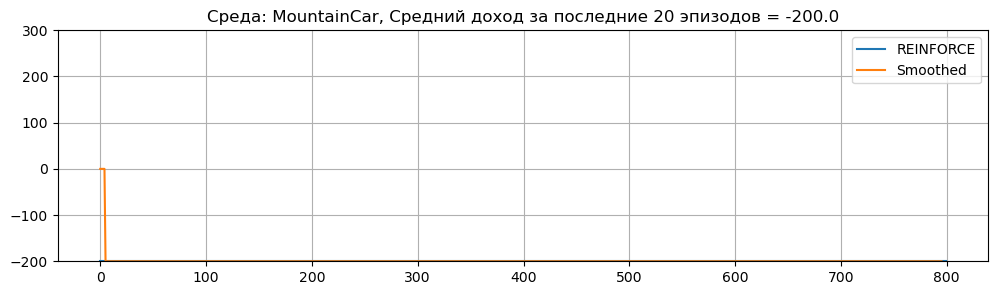

In [133]:
def plot_rewards(env_name, returns, label):
    # сглаженный вектор доходов
    returns_smoothed = np.pad(np.convolve(returns, np.ones(10)/10, mode='valid'),[5, 0])
    fig = plt.figure(figsize=(12, 3))
    plt.title("Среда: "+env_name+", Средний доход за последние 20 эпизодов = "+str(np.mean(returns[-20:])))
    plt.plot(returns, label=label)
    plt.plot(returns_smoothed, label="Smoothed")
    plt.grid()
    plt.legend()
    plt.ylim(-200, 300)
    plt.show()

returns = np.array(env.return_queue)
plot_rewards("MountainCar", returns, 'REINFORCE')

Исходный алгоритм REINFORCE для этой задачи не работает из-за слишком скудной системы вознаграждений. 

Увеличим вознаграждение за достижения более правых позиций.

In [39]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        #self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 96)
        self.fc2 = nn.Linear(96, action_size)
        
    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        prob_distribution = Categorical(F.softmax(x, dim=-1))
        return prob_distribution

In [40]:
def REINFORCE_control_MountCar(env, agent, num_episodes=10000, goal_score=250):
    gains = []
    for i in range(num_episodes):
        state, _ = env.reset()
        terminated, truncated = False, False
        rewards = []
        true_rewards = []
    
        while not terminated and not truncated:
            action = agent.get_action(state)
            state, reward, terminated, truncated, _ = env.step(action)
            true_rewards.append(reward) 
            #print(reward)
            #print(np.abs(state[1]))
            reward = reward + 2*np.abs(state[1])
            rewards.append(reward)
            
    
        agent.update(rewards)
        gains.append(np.sum(true_rewards))
        if i % 10 == 0:
            print("\rЭпизод: {}, Доход: {}, Средний доход: {}".format(i, np.sum(true_rewards), np.mean(gains[-100:])), end="")

        if np.mean(gains[-100:]) > goal_score:
            print("\nФиниш!")
            break

    return gains

In [41]:
env = gym.make("MountainCar-v0", max_episode_steps=500)
agent = REINFORCE_Agent(env, model, alpha = 0.01, normalize = False)

state, _ = env.reset()
agent.best_action(state)

gains = REINFORCE_control_MountCar(env, agent, num_episodes=750, goal_score=-110)

Эпизод: 740, Доход: -500.0, Средний доход: -500.0

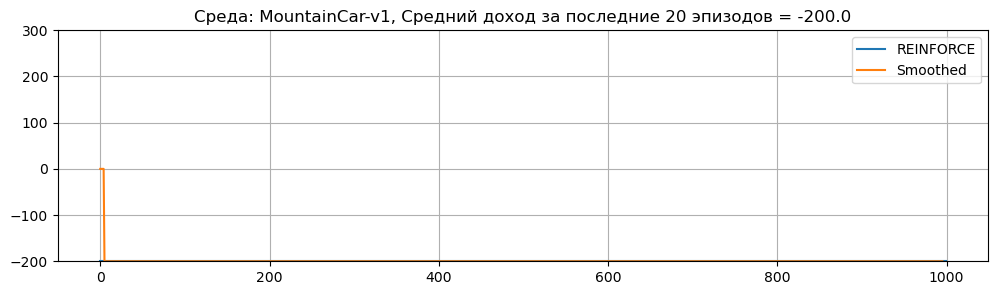

In [100]:
gains_smoothed = np.pad(np.convolve(gains, np.ones(10)/10, mode='valid'),[5, 0])

fig = plt.figure(figsize=(12, 3))
plt.title("Среда: "+ "MountainCar-v1" +", Средний доход за последние 20 эпизодов = "+str(np.mean(gains[-20:])))
plt.plot(gains, label="REINFORCE")
plt.plot(gains_smoothed, label="Smoothed")
plt.grid()
plt.legend()
plt.ylim(-200, 300)
plt.show()